In [1]:
%matplotlib inline

In [2]:
!hostname

mum-hpc2-gpu4


In [3]:
%cd ICRA_2023

/home/ssap0002/ICRA_2023


In [4]:
from VRNN_DAT import VRNN_DAT
from RNN import GRU, LSTM
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

2023-03-01 14:23:19.071023: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Loading

In [5]:
import os
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ORI_DATA_DIR = 'data/gripper/full'
HALF_DATA_DIR = 'data/gripper/half'
SYNTH_DATA_DIR = 'output/'

In [6]:
def to_timeseries(X, y, time_steps = 50):
    dataX = []
    dataY = []
    # Cut data by sequence length
    for i in range(0, len(X) - time_steps):
        _x = X[i:i+time_steps, :]
        _y = y[i:i+time_steps, :]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

def revert_timeseries(X, time_steps = 100):
  # if len(X[0]) == time_steps and time_steps != 1:
  #   return np.array(X[0])
  head = X[0]
  tail = np.array([f[time_steps-1] for f in X])
  return np.concatenate((head, tail))

def load_pickle(filepath):
    with open(filepath,'rb') as f:
      x = pickle.load(f)
      return x
    
def _preprocess(data):
  # Features
  flex = data['Flex'][0]
  pressure = data['Pressure'][0]

  # Labels
  f1, f2 = data['Force']
  x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = data['PosX']
  y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = data['PosY']
      
  x = list(zip(flex, pressure, f1, f2, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))
  return np.array(x)

def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_data(s, _from='Train', scaler=None):
  raw_data = load_pickle("data/new_soro_all.pkl")
  train = raw_data.xs(_from, axis=0, level=1, drop_level=True)

  raw_data = _preprocess(train[s])

  # Normalize 
  if scaler is None:
      label_scaler = MinMaxScaler(clip=True)
      feature_scaler = MinMaxScaler(clip=True)
    
      features, labels = feature_scaler.fit_transform(raw_data[:, :2]), label_scaler.fit_transform(raw_data[:, 2:])
      print(f"creating scaler from {s}")
      
  else:
    print("reusing scaler")
    label_scaler, feature_scaler = scaler
    features, labels = feature_scaler.transform(raw_data[:, :2]), label_scaler.transform(raw_data[:, 2:])
    

  # Timeseries
  X_train, y_train = to_timeseries(features, labels, params['timesteps'])

  # return  X_train, y_train, (label_scaler, feature_scaler)
  if s in params['SOURCE']:
      return  X_train[-2000:], y_train[-2000:], (label_scaler, feature_scaler)        
  return  X_train[:3000], y_train[:3000], (label_scaler, feature_scaler)

In [7]:
def load_dataset(datatype, datasets, batch_size, no_state_data=[], scaler=None):
    X_train, y_train, domain_labels = [], [], []
    
    if datatype == 'test':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Test', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            print(len(_x))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        for i, (x,y) in enumerate(zip(X_train, y_train)):
            if i == 0:
                dataset = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                dataset = dataset.batch(batch_size)
            
            else: 
                _d = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                _d = _d.batch(batch_size)
                dataset = dataset.concatenate(_d)
        return dataset, scaler
    
    elif datatype == 'train':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Train', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        Xdata = np.concatenate(X_train)
        ydata = np.concatenate(y_train)
        Statedata = np.concatenate(domain_labels).astype(np.float32)

        # Shuffle
        p = np.random.permutation(len(Xdata))
        Xdata = Xdata[p]
        ydata = ydata[p]
        Statedata = Statedata[p]

        dataset =  tf.data.Dataset.from_tensor_slices((Xdata ,ydata, Statedata))
        return dataset.batch(batch_size), scaler

In [8]:
def get_dataset(model_type, train_scenario, batch_size):
    
    if train_scenario == "tip_contact":        
        all_datasets = ['osc_tip_30', 'osc_rand_30', 'rand_tip_30', 'rand_rand_60']
    elif train_scenario == "random_contact":
        all_datasets = ['osc_rand_30', 'rand_rand_60','osc_tip_30', 'rand_tip_30']
        
    if train_scenario == "tip_contact":
        _train_d = ['osc_tip_30', 'rand_tip_30']
    elif train_scenario == "random_contact":
        _train_d = ['osc_rand_30', 'rand_rand_60']
    
    # _test_d = [d for d in all_datasets if d not in _train_d]
    _test_d = [d for d in all_datasets]
    
        
    if model_type == "GRU" or model_type == "LSTM":           
        train_dataset, scaler = load_dataset('train', _train_d, batch_size)
    
    elif "VRNN_DAT" in model_type:
        train_dataset, scaler = load_dataset('train', all_datasets, batch_size, no_state_data=_test_d)
        
    test_dataset, _ = load_dataset('test', _test_d, batch_size, scaler=scaler)
    
    return train_dataset, test_dataset, scaler

def get_model(model_type, params=None):
    if model_type == "GRU":
        return GRU(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "LSTM":
        return LSTM(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "VRNN":
        pass
    elif "VRNN_DAT" in model_type:
        return VRNN_DAT(params['x_dim'], params['h_dim'], params['z_dim'], phi_x_dim=params['phi_x_dim'], d_dim=params['d_dim'], vrnn_lr=params['lr'], adv_lr=params['adv_lr'], clip=params['clip'], rnn=params['rnn'])

def evaluate_model(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)
    
    force_x_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    force_z_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    marker_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    
    force_x_rmse_metric.update_state(y_test[:, :, 0], pred[:, :, 0]).numpy()
    force_z_rmse_metric.update_state(y_test[:, :, 1], pred[:, :, 1]).numpy()
    
    force_rmse = (force_x_rmse_metric.result().numpy(), force_z_rmse_metric.result().numpy())

    marker_rmse_metric.update_state(y_test[:, :, 2:], pred[:, :, 2:]).numpy()
    marker_rmse = marker_rmse_metric.result().numpy()
    
    return force_rmse, marker_rmse

def evaluate_model2(model, test_dataset, scaler):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = scaler[0].inverse_transform(revert_timeseries(np.concatenate(pred), timesteps))
    y_test = scaler[0].inverse_transform(revert_timeseries(np.concatenate(y_test), timesteps))
    
    force_x_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    force_z_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    marker_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    
    force_x_rmse_metric.update_state(y_test[:, 0], pred[:, 0]).numpy()
    force_z_rmse_metric.update_state(y_test[:, 1], pred[:, 1]).numpy()
    
    force_rmse = (force_x_rmse_metric.result().numpy(), force_z_rmse_metric.result().numpy())

    marker_rmse_metric.update_state(y_test[:, 2:], pred[:, 2:]).numpy()
    marker_rmse = marker_rmse_metric.result().numpy()
    
    return force_rmse, marker_rmse

## Hyperparameters

In [9]:
x_dim = 2 # flex + pressure
h_dim = 128
z_dim = 22 # 2 force + 10*2D coordinates
phi_x_dim = 32
d_dim = 128
n_epochs = 50
clip = 5
lr = 1e-3
adv_lr = 1e-3
batch_size = 128 # 32
seed = 261199
timesteps=100
rnn="GRU"
# tf.random.set_seed(seed)

In [10]:
from sorcery import dict_of

params = dict_of(x_dim, h_dim, z_dim, phi_x_dim, timesteps, d_dim, n_epochs, clip, lr, adv_lr, batch_size, rnn)

## Load Models

In [11]:
def load_model(model_type, train_scenario, run=3):
    print(f"================={model_type}:{train_scenario}:{run}==================")
    # Prepare dataset and model
    if model_type == "VRNN_DAT_GRU":
        params['rnn'] = 'GRU'
    elif model_type == "VRNN_DAT_LSTM":
        params['rnn'] = 'LSTM'
        
    train_dataset, test_dataset, scalers = get_dataset(model_type, train_scenario, params['batch_size'])
    model = get_model(model_type, params)

    # Train
    if model_type == "GRU" or model_type == "LSTM":
        model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
    else:
        model.compile()

    # Save weights
    model.load_weights(f"weights/one_scaler/{model_type}/{train_scenario}/run_{run}/")
    print("loaded model")
    
#     # Evaluate
    # (force_x_rmse, force_z_rmse), marker_rmse = evaluate_model(model, test_dataset)

#     # Write to df
    # print(f"================={model_type}:{train_scenario}:{run}:{force_x_rmse}:{force_z_rmse}:{marker_rmse}==================") 
    
    return model

def get_estimated_state(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    return pred

def get_latent_measurement(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.get_feature_representation(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    return pred

In [19]:
train_scenario = 'tip_contact'

if train_scenario == "tip_contact":
    params['SOURCE'] = ['osc_tip_30', 'rand_tip_30']
else:
    params['SOURCE'] = ['osc_rand_30', 'rand_rand_60']


vrnn_dat = load_model('VRNN_DAT_LSTM', train_scenario, 1)
# lstm = load_model("LSTM", train_scenario)
gru = load_model("GRU", train_scenario, 1)

=================VRNN_DAT_LSTM:tip_contact:1==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
2000
reusing scaler
2900
reusing scaler
2000
reusing scaler
3000
DAT on Zt
Using LSTM Backend
loaded model
=================GRU:tip_contact:1==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
2000
reusing scaler
2900
reusing scaler
2000
reusing scaler
3000
loaded model


In [20]:
train_dataset, test_dataset, scalers = get_dataset("GRU", train_scenario, params['batch_size'])
# label_scaler = scalers[0]

creating scaler from osc_tip_30
reusing scaler
reusing scaler
2000
reusing scaler
2900
reusing scaler
2000
reusing scaler
3000


In [21]:
for i, (x,y,state) in enumerate(test_dataset.unbatch().as_numpy_iterator()):
    pass
print(i+101)

10000


## Estimations

In [22]:
plt.style.use('seaborn')
def plot(axes, model, test_dataset, color='blue', l="label", vrnn=False, run=0, lw=1):
    pred, y_test = [] , []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        if not vrnn:
            _pred = model.predict(x_batch_test)
        else:
            _pred = model.predict(x_batch_test)
            
        pred.append(_pred)
        y_test.append(y_batch_test)

    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)

    pred = revert_timeseries(pred, timesteps)
    
    # predicted_arr = revert_scaling(scalers, pred)
    
    # predicted_arr = scalers[0].inverse_transform(pred)
    predicted_arr = pred
    
    
    osc = np.concatenate([predicted_arr[:1000], predicted_arr[2000:3000], predicted_arr[1000:2000], predicted_arr[3000:5000], predicted_arr[1500:2000]])
    rand = np.concatenate([predicted_arr[5000:6000], predicted_arr[7000:8000], predicted_arr[6000:7000], predicted_arr[8000:]])
    predicted_arr = np.concatenate([osc, rand ])
    
    
    
    # predicted_arr = scalers[0].inverse_transform(predicted_arr)
    resultant_force = np.sqrt( np.square(predicted_arr[:, 0]) + np.square(predicted_arr[:, 1]) )
    if train_scenario == "random_contact":
          resultant_force[resultant_force >= 0.62] = 0.61 
    
    
    x_tip = predicted_arr[:, 11]
    y_tip = predicted_arr[:, -1]
    resultant_markers = np.sqrt( np.square(x_tip) + np.square(y_tip) )
    
    # resultant_markers = np.abs(scalers[0].inverse_transform(np.concatenate([np.zeros((resultant_markers.shape[0], 21)), resultant_markers.reshape((-1,1))], axis=-1))[:, -1])
    
    
        
    a1,a2 = axes
    # if vrnn:
    #     predicted_arr[:, 1] = predicted_arr[:, 1]+0.5
    
    x = 0.1*np.arange(np.shape(predicted_arr[:])[0])

    a1.plot(x, resultant_force, label=l, linewidth=lw, color=color)

    # a2.plot(x, predicted_arr[:, 1], label=l, linewidth=lw+2)
           

    a2.plot(x, resultant_markers, label=l, linewidth=lw+2, color=color)

    # a3.plot(x, predicted_arr[:, -1], label=l, linewidth=lw+2, color=color)



In [23]:
import seaborn as sns
sns.color_palette()


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [24]:
if train_scenario == "tip_contact":
    plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
    plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
else:
    plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
    plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def plot_all(test_dataset, lw=1):
    titleSize = 65; subtitleSize = 50; labelSize = 50; tickSize = 40; legendSize = 60
    plt.style.use('seaborn-darkgrid')
    y_test = []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        y_test.append(y_batch_test)

    y_test = np.concatenate(y_test)
    
    # plotted_y_test = scalers[0].inverse_transform(revert_timeseries(y_test, timesteps))
    plotted_y_test = revert_timeseries(y_test, timesteps)
    
    osc = np.concatenate([plotted_y_test[:1000], plotted_y_test[2000:3000], plotted_y_test[1000:2000], plotted_y_test[3000:5000], plotted_y_test[1500:2000]])
    rand = np.concatenate([plotted_y_test[5000:6000], plotted_y_test[7000:8000], plotted_y_test[6000:7000], plotted_y_test[8000:]])
    plotted_y_test = np.concatenate([osc, rand ])
    # plotted_y_test = np.concatenate([plotted_y_test[250:750, :], np.zeros((7000, 22))])
    print(plotted_y_test.shape)

    
    # resultant_markers = np.abs(scalers[0].inverse_transform(np.concatenate([np.zeros((resultant_markers.shape[0], 21)), resultant_markers.reshape((-1,1))], axis=-1))[:, -1])
    
    # plotted_y_test = scalers[0].inverse_transform(plotted_y_test)
    force_labels_x = plotted_y_test[:, 0]
    force_labels_z = plotted_y_test[:, 1]      
    
    x_tip = plotted_y_test[:, 11]
    y_tip = plotted_y_test[:, -1]
    resultant_markers = np.sqrt( np.square(x_tip) + np.square(y_tip) )
    
    resultant_force = np.sqrt( np.square(force_labels_x) + np.square(force_labels_z) )
    
    if train_scenario == "random_contact":
        resultant_force[resultant_force >= 0.62] = 0.61
    
    labels_arr = [resultant_force, resultant_markers]
    x_title = ["Force X (N)", "Force Z (N)", "X Tip", "Y Tip"]

    f, (a1,a2) = plt.subplots(2,1,sharex=True, figsize=(30,20))
    # f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True)  
    print(f.get_facecolor())

    x = 0.1*np.arange(np.shape(plotted_y_test)[0])
    print(len(x))
    axes = (a1, a2)
    labels = ["GRU", "DSVB-GRU"]

    ESTIMATIONS = []
    # c = [sns.color_palette()[0], sns.color_palette()[4], sns.color_palette()[1]]
    c = [sns.color_palette()[1], sns.color_palette()[0]]

    for i, model in enumerate([gru, vrnn_dat]):
        ESTIMATIONS.append(plot(axes, model, test_dataset, l=labels[i], vrnn=True if labels[i] == "DSVB" else False, color=c[i], lw=lw))

    a1.plot(x,labels_arr[0], linestyle="--", label='Ground Truth', linewidth=lw, color=sns.color_palette()[2])
    a1.grid(linestyle = '-',)

    a2.plot(x, labels_arr[1], linestyle="--", label='Ground Truth', linewidth=lw+2, color=sns.color_palette()[2])
    a2.grid(linestyle = '-',)

    # a3.grid(linestyle = '-',)
    # a3.plot(x, labels_arr[2],  linestyle="--", label='Ground Truth', linewidth=lw+2, color=sns.color_palette()[2])

    # a4.grid(linestyle = '-',)
    # a4.plot(x, labels_arr[3], linestyle="--", label='Ground Truth', linewidth=lw+2)
    
    f.tight_layout()
    
    
    a2.set_xlabel("Time (s)", fontsize=labelSize)
    
    ymax, ymin = 0.98, 0.02
    a1.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a3.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    a1.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a3.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    
    a1.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a3.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    a1.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a3.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    # a1.set_ylim((-0.1, None))
    
    if train_scenario == "tip_contact":
        a1.set_title("Transfer Scenario 1: Surface Contact (target domain)", fontsize=titleSize)
        a1.set_ylim((0.18, None))
        a2.set_ylim((None, 1.74999999))
        a1.annotate("Oscillatory Actuation", (120, 1.5), fontsize=legendSize)
        a1.annotate("Random Actuation", (700, 1.5), fontsize=legendSize)  
    else:
        a1.set_title("Transfer Scenario 2: Tip Contact (target domain)", fontsize=titleSize)    
        a1.set_ylim((None, None))
        a2.set_ylim((None, None))
          
    
    a1.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    a2.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    # a3.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    # a4.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=4, zorder=-100)
    
    
    # a1.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a2.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a3.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a4.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    
    if train_scenario == "tip_contact":
        # a2.set_ylim((-0.09, None))
        a1.set_ylabel('Resultant Force (N)', fontsize=labelSize)
        a2.set_ylabel('Tip Marker Position (m)', fontsize=labelSize)
        # a3.set_ylabel('Y Marker Tip', fontsize=labelSize)
    else:
        a2.legend(fontsize=legendSize)
        
    # a4.set_ylabel('Y Marker Tip', fontsize=labelSize)
    
    a1.tick_params(axis='both', labelsize=tickSize)
    a2.tick_params(axis='both', labelsize=tickSize)
    # a3.tick_params(axis='both', labelsize=tickSize)
    # a4.tick_params(axis='both', labelsize=tickSize)
    # a1.grid(False)
    print(a1.get_ylim())
    print(a2.get_ylim())
    
    # a2.legend()
    # a3.legend()
    # a4.legend()
    plt.savefig(f"{train_scenario}(source)_estimation.png", dpi=300, bbox_inches = 'tight', pad_inches = 0)
    # plt.savefig(f"text.png", dpi=300, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()


(10500, 22)
(1.0, 1.0, 1.0, 1.0)
10500
2/2 [==============================] - 0s 3ms/step
(0.18, 1.4744824327528476)
(0.043047940358519554, 1.74999999)


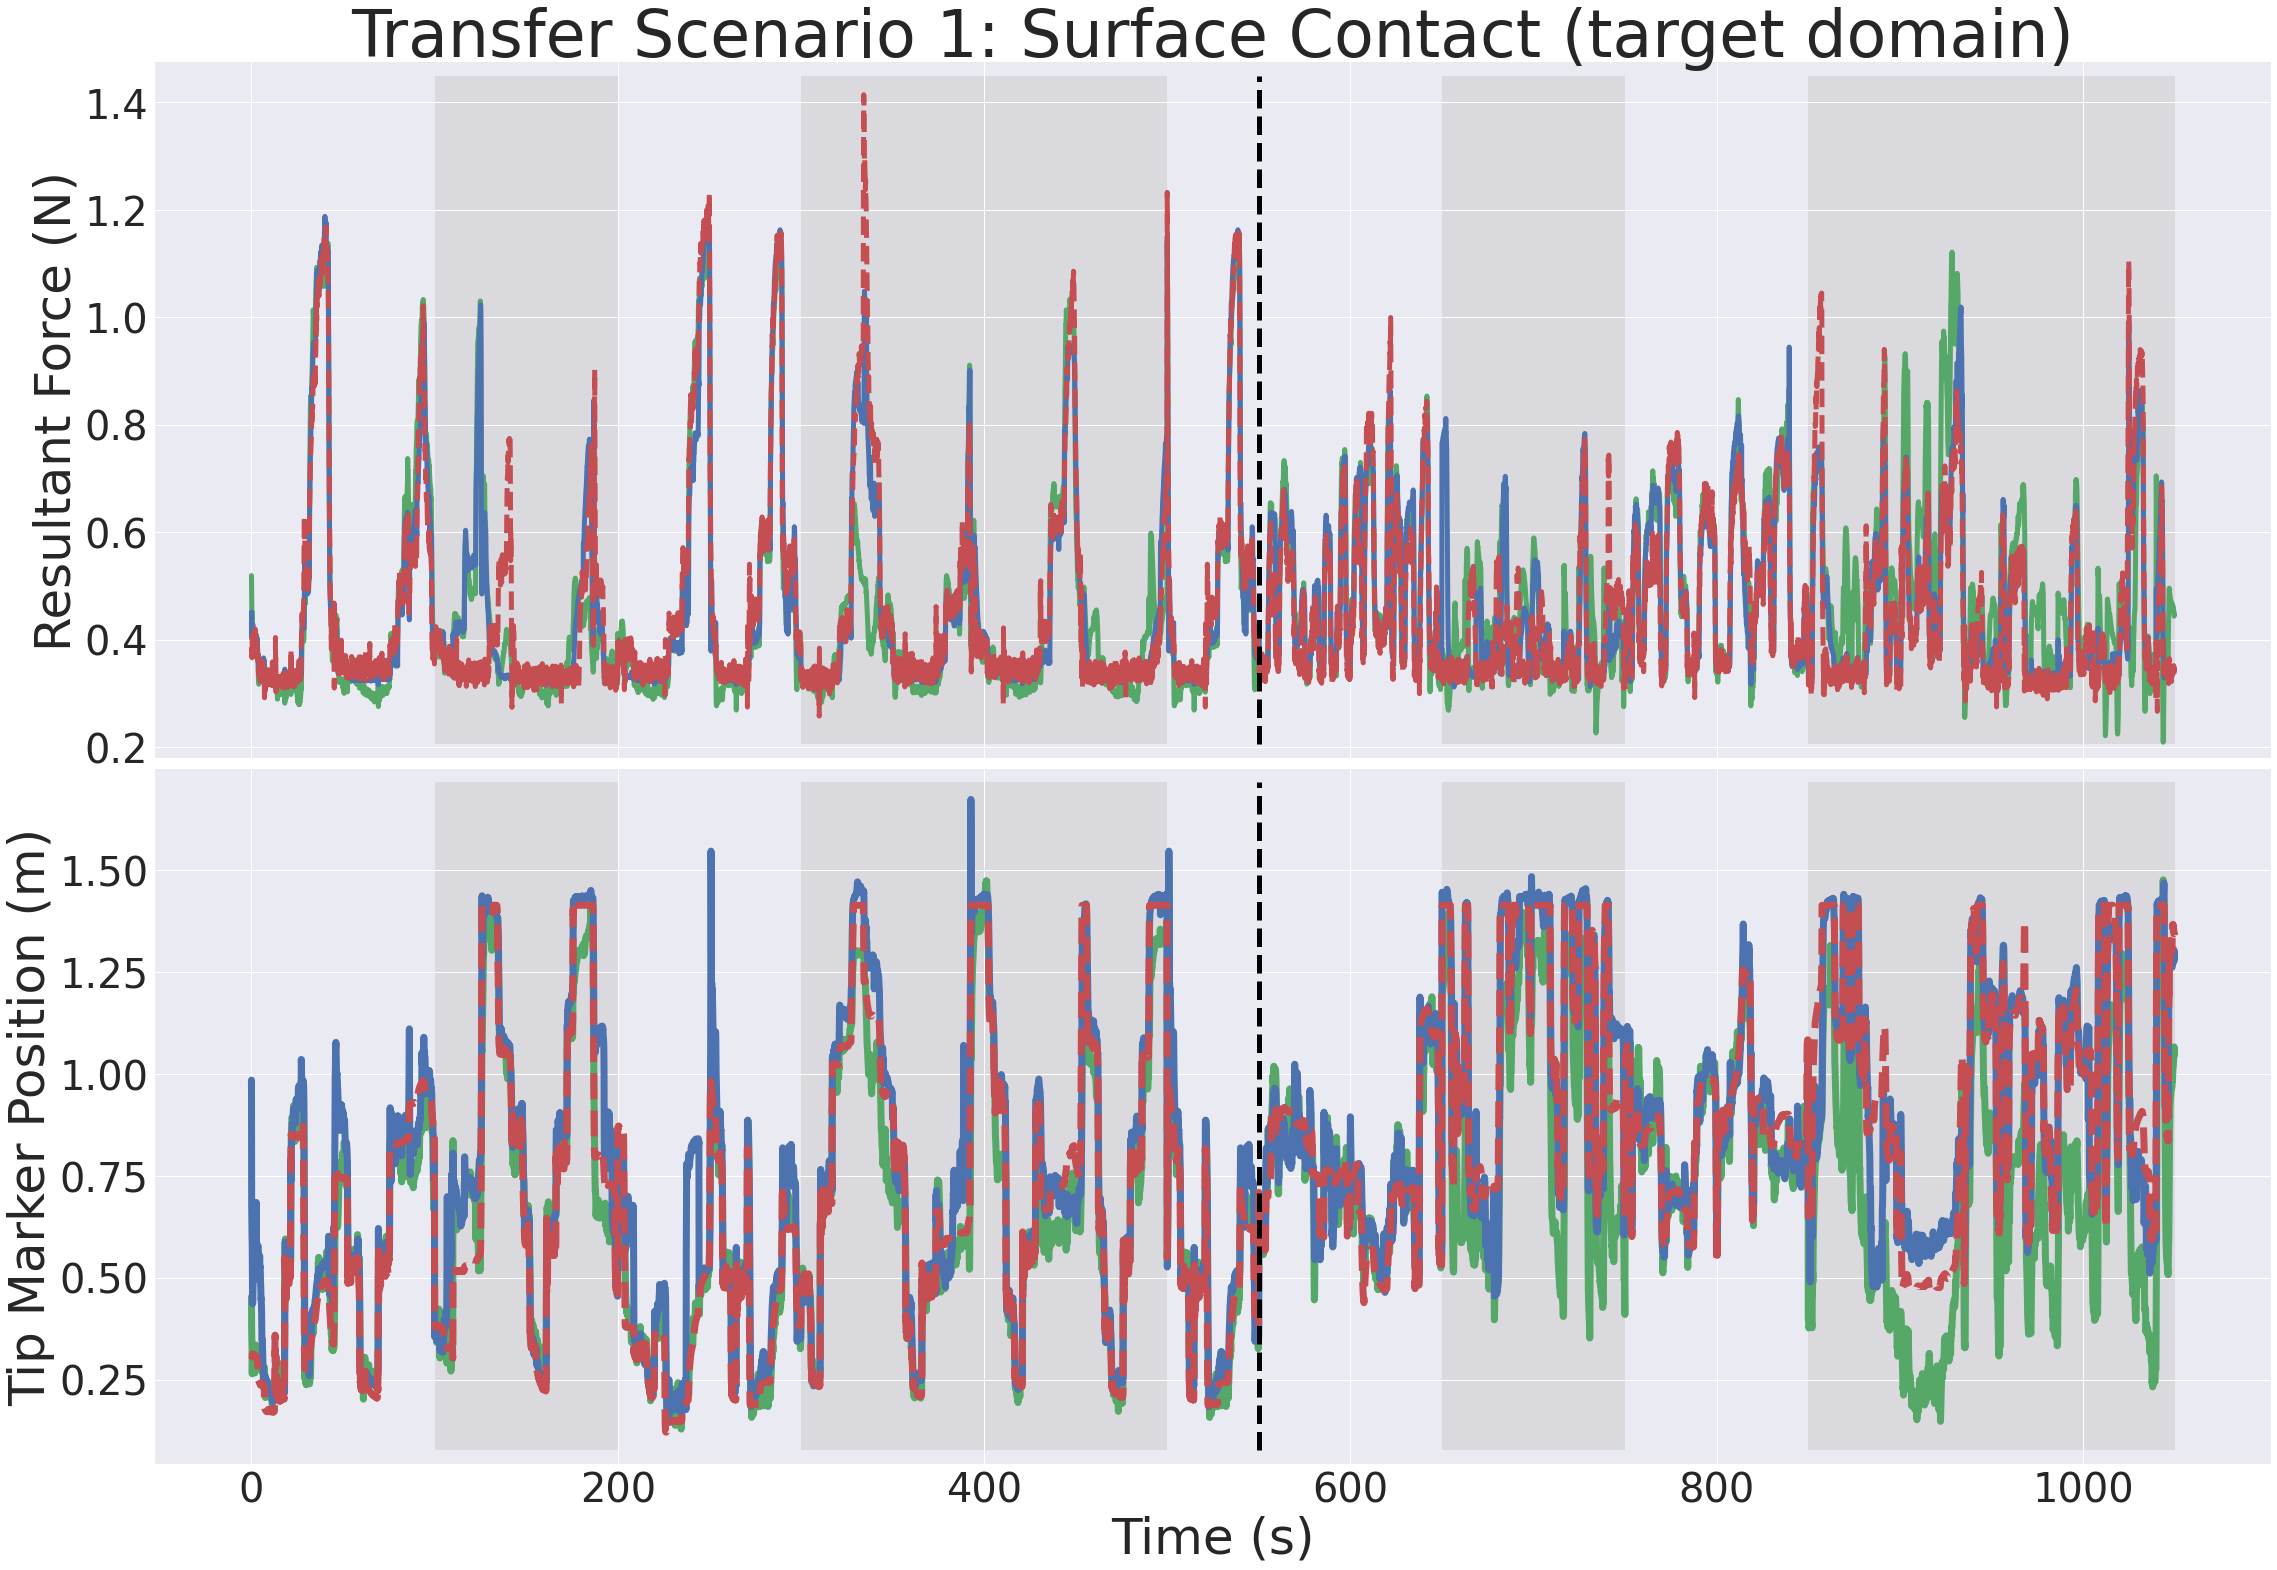

In [25]:
plot_all(test_dataset, lw=5)

## Error PLot

In [42]:
def get_errors(y_true, y_pred):
    return (y_true-y_pred).mean(axis=-1)

In [43]:
plt.style.use('seaborn')
def plot_errors(axes, model, test_dataset, color='blue', l="label", vrnn=False, run=0, lw=1, z=2):
    pred, y_test = [] , []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        if not vrnn:
            _pred = model.predict(x_batch_test, verbose=0)
        else:
            _pred = model.predict(x_batch_test)
            
        pred.append(_pred)
        y_test.append(y_batch_test)

    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)
    print(pred.shape, y_test.shape)

    pred = scalers[0].inverse_transform(revert_timeseries(pred, timesteps))
    y_test = scalers[0].inverse_transform(revert_timeseries(y_test, timesteps))
    print(pred.shape, y_test.shape)
    
    
    # predicted_arr = revert_scaling(scalers, pred)
    
    osc = np.concatenate([pred[:1000], pred[2000:3000], pred[1000:2000], pred[3000:5000], pred[1500:2000]])
    rand = np.concatenate([pred[5000:6000], pred[7000:8000], pred[6000:7000], pred[8000:]])
    predicted_arr = np.concatenate([osc, rand ])
    
    rosc = np.concatenate([y_test[:1000], y_test[2000:3000], y_test[1000:2000], y_test[3000:5000], y_test[1500:2000]])
    rrand = np.concatenate([y_test[5000:6000], y_test[7000:8000], y_test[6000:7000], y_test[8000:]])
    real_arr = np.concatenate([rosc, rrand ])
    
    print(predicted_arr.shape, real_arr.shape)
    
    
    resultant_force = np.sqrt( np.square(real_arr[:, 0]) + np.square(real_arr[:, 1]) )
    pred_resultant_force = np.sqrt( np.square(predicted_arr[:, 0]) + np.square(predicted_arr[:, 1]) )
    
    
    force_errors = get_errors(resultant_force.reshape((-1,1)), pred_resultant_force.reshape((-1,1)))
    marker_errors = get_errors(real_arr[:, 2:], predicted_arr[:, 2:])
    print(force_errors.shape, marker_errors.shape)
    a1,a2 = axes
    # if vrnn:
    #     predicted_arr[:, 1] = predicted_arr[:, 1]+0.5
    
    x = 0.1*np.arange(len(force_errors))

    a1.plot(x, force_errors, label=l, linewidth=lw, zorder=z)

    # a2.plot(x, predicted_arr[:, 1], label=l, linewidth=lw+2)
           

    a2.plot(x, marker_errors, label=l, linewidth=lw+2, zorder=z)




In [44]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def plot_all_errors(test_dataset, lw=1):
    titleSize = 45; subtitleSize = 40; labelSize = 40; tickSize = 30; legendSize = 35
    plt.style.use('seaborn-darkgrid')

    f, (a1,a2) = plt.subplots(2,1,sharex=True, figsize=(30,30)) 

    axes = (a1, a2)
    labels = ["GRU", "DSVB"]

    ESTIMATIONS = []
    # c = [sns.color_palette()[0], sns.color_palette()[4], sns.color_palette()[1]]
    c = ["g", "b"]
    z=[2, 1]

    for i, model in enumerate([gru, vrnn_dat]):
        ESTIMATIONS.append(plot_errors(axes, model, test_dataset, l=labels[i], vrnn=True if labels[i] == "DSVB" else False, color=c[i], lw=lw, z=z[i]))

    
    a1.grid(linestyle = '-',)


    a2.grid(linestyle = '-',)


    # a4.grid(linestyle = '-',)
    # a4.plot(x, labels_arr[3], linestyle="--", label='Ground Truth', linewidth=lw+2)
    
    f.tight_layout()
    
    a2.set_xlabel("Time (s)", fontsize=labelSize)
    
    ymax, ymin = 0.98, 0.02
    a1.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(100, 200, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    a1.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(300, 500, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    
    a1.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(650, 750, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    a1.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    a2.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    # a4.axvspan(850, 1050, facecolor='0.8', ymin=ymin, ymax=ymax, alpha=0.5, zorder=-100)
    
    
    # a1.set_ylim((None, 2))
    # a3.set_ylim((-0.09, None))
    
    
    a1.legend(fontsize=legendSize)
    
    # a1.set_title("Tip Contact (source domain), Surface Contact (target domain)", fontsize=titleSize)
    # a1.set_title("Surface Contact (source domain), Tip Contact (target domain)", fontsize=titleSize)
    
    # a1.annotate("Oscillatory Actuation", (165, 1.75), fontsize=legendSize)
    # a1.annotate("Random Actuation", (740, 1.75), fontsize=legendSize)
    
    # a1.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    # a2.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    
    a1.axhline(y=0, linestyle="--", color="black", linewidth=5, zorder=0)
    a2.axhline(y=0, linestyle="--", color="black", linewidth=5, zorder=0)
    
    
    # a3.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=5, zorder=100)
    # a4.axvline(x=550, linestyle="--", color="black", ymin=ymin, ymax=ymax, linewidth=4, zorder=-100)
    
    
    # a1.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a2.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a3.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    # a4.tick_params(left = False, labelleft = False, axis='both', labelsize=tickSize)
    
    a1.set_ylabel('Resultant Force (N)', fontsize=labelSize)
    a2.set_ylabel('Markers', fontsize=labelSize)
    # a3.set_ylabel('Y Marker Tip', fontsize=labelSize)
    # a4.set_ylabel('Y Marker Tip', fontsize=labelSize)
    
    a1.tick_params(axis='both', labelsize=tickSize)
    a2.tick_params(axis='both', labelsize=tickSize)
    # a3.tick_params(axis='both', labelsize=tickSize)
    # a4.tick_params(axis='both', labelsize=tickSize)
    
    # a2.legend()
    # a3.legend()
    # a4.legend()
    plt.savefig("scenario1_prediction_errors.png", dpi=300, bbox_inches = 'tight', pad_inches = 0)
    plt.show()


[W 2022-09-09 02:37:53,817.817 tensorflow] Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
[W 2022-09-09 02:37:53,817.817 tensorflow] Value in checkpoint could not be found in the restored object: (root).prior.kernel
[W 2022-09-09 02:37:53,818.818 tensorflow] Value in checkpoint could not be found in the restored object: (root).prior.bias
[W 2022-09-09 02:37:53,818.818 tensorflow] Value in checkpoint could not be found in the restored object: (root).prior_mean.kernel
[W 2022-09-09 02:37:53,818.818 tensorflow] Value in checkpoint could not be found in the restored object: (root).prior_mean.bias
[W 2022-09-09 02:37:53,818.818 tensorflow] Value in checkpoint could not be found in th

(9800, 100, 22) (9800, 100, 22)
(9900, 22) (9900, 22)
(10400, 22) (10400, 22)
(10400,) (10400,)
(9800, 100, 22) (9800, 100, 22)
(9900, 22) (9900, 22)
(10400, 22) (10400, 22)
(10400,) (10400,)


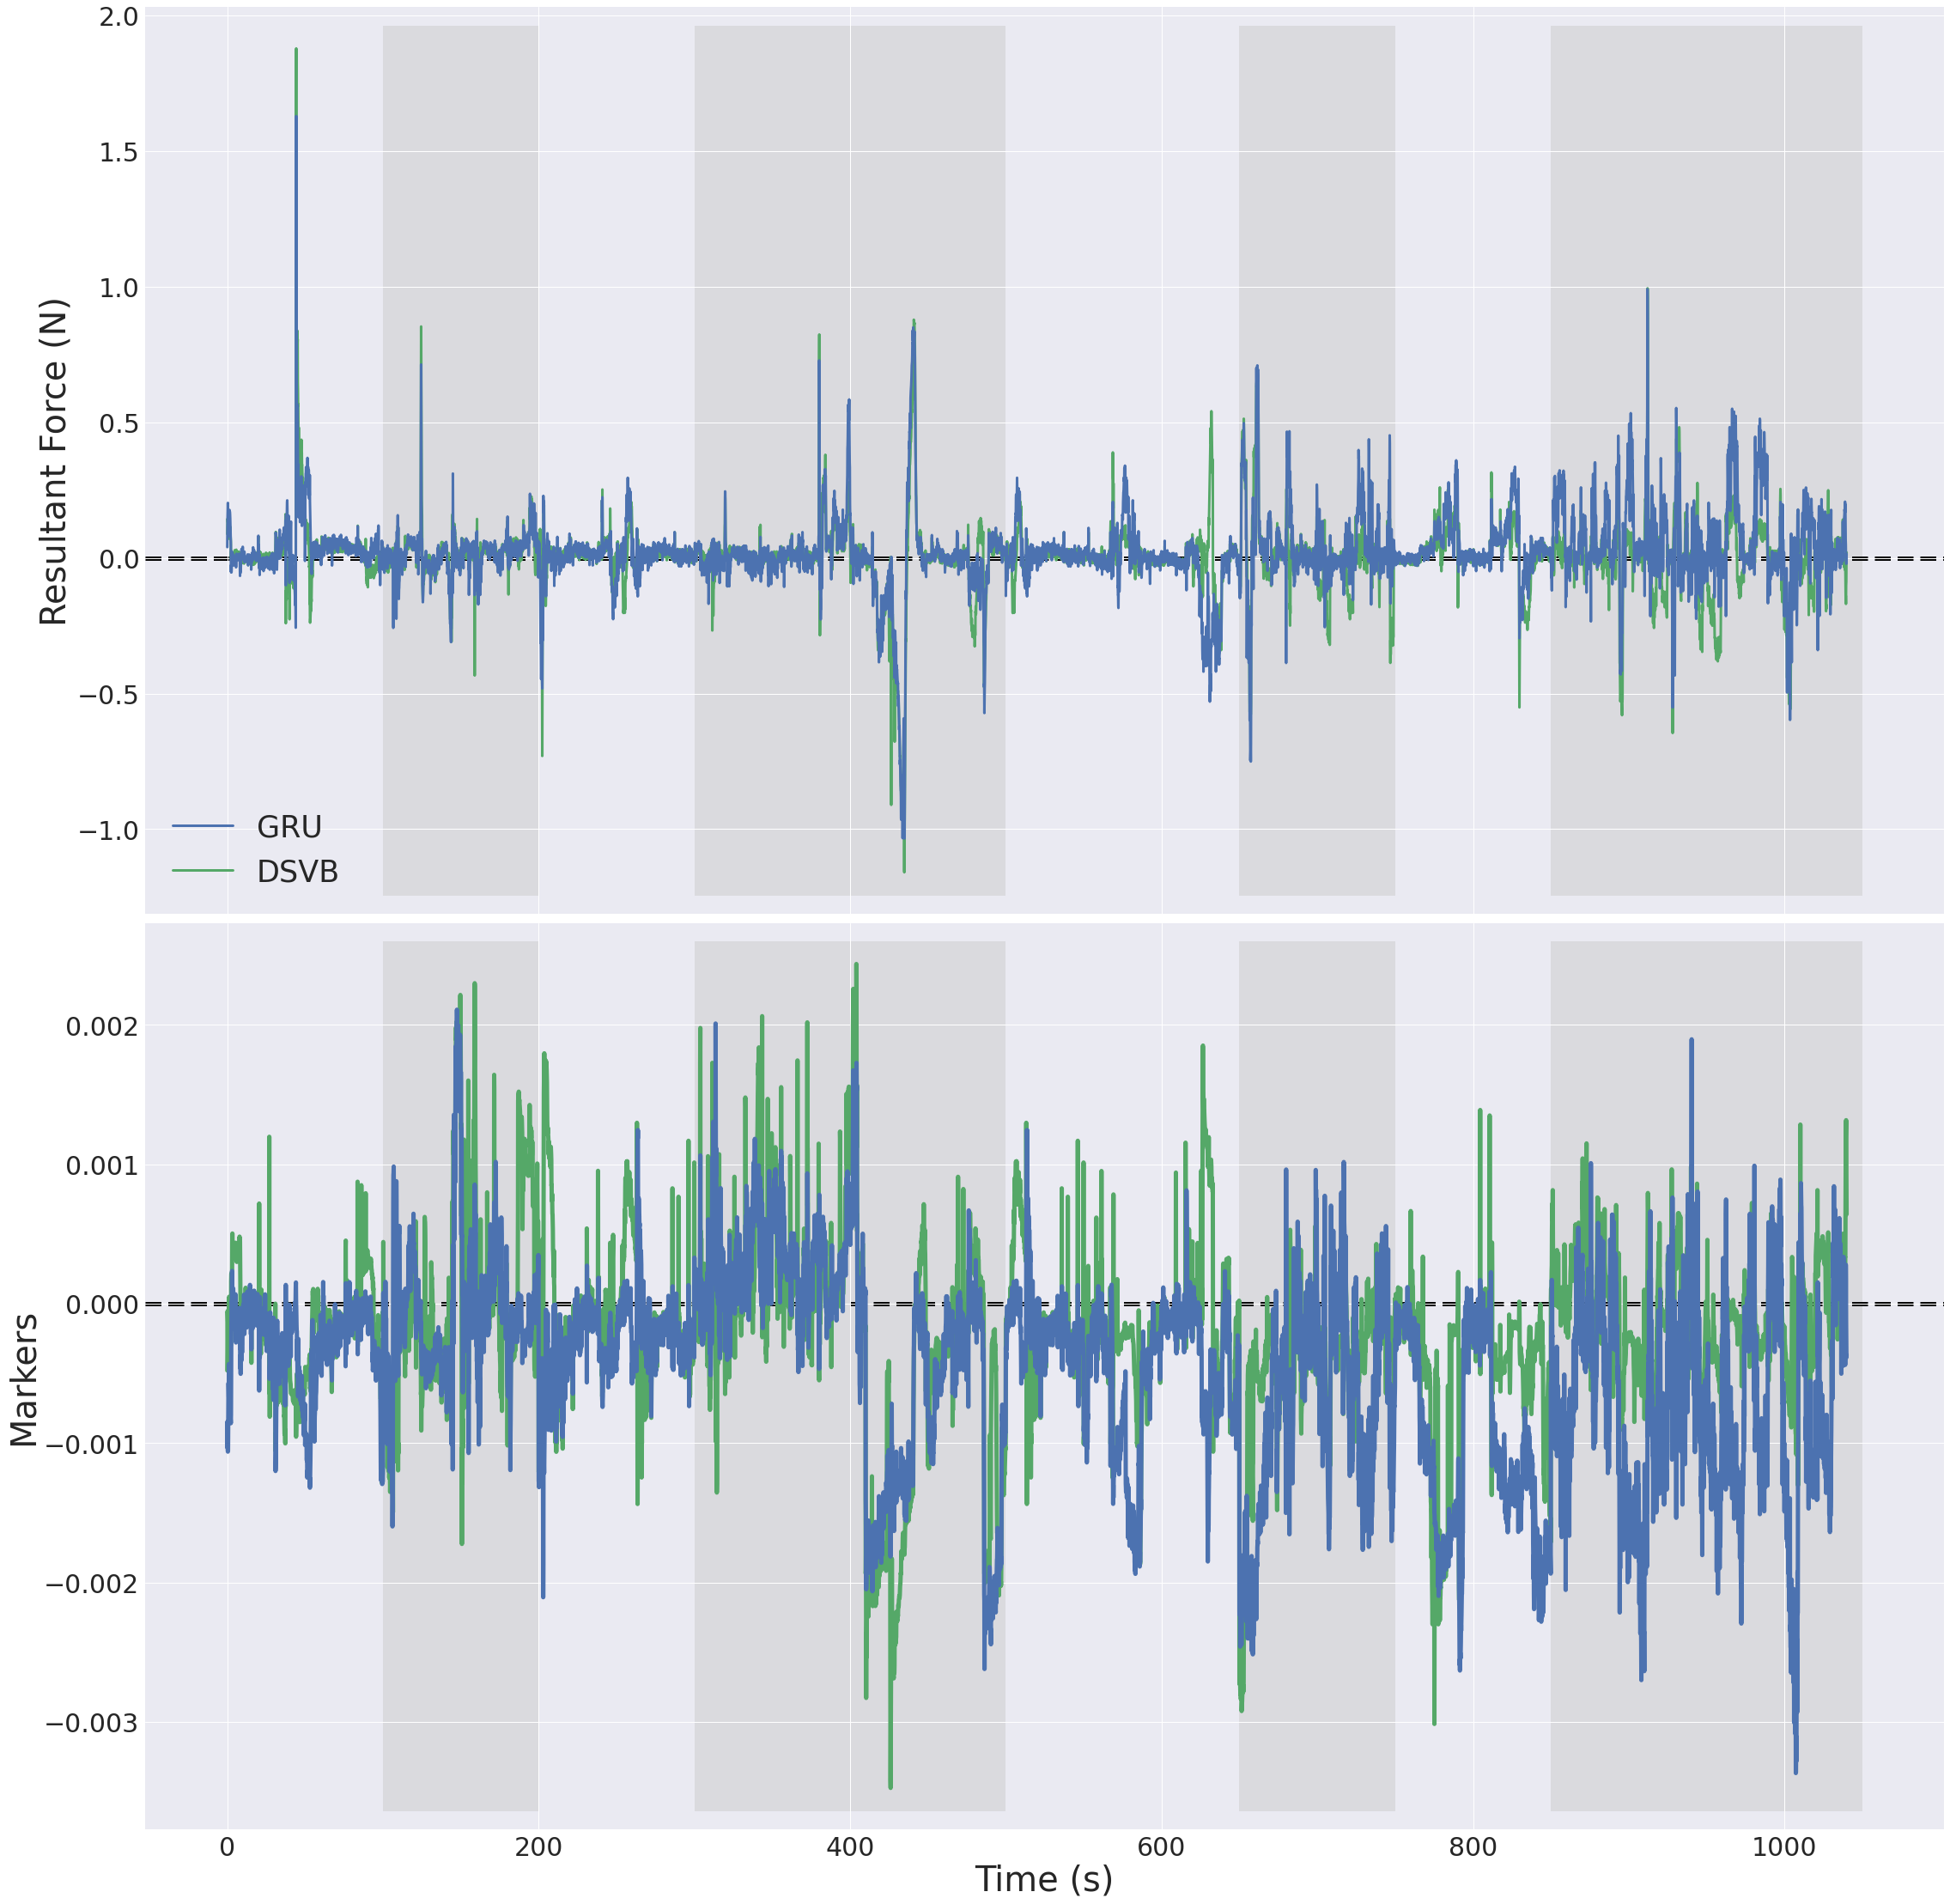

In [45]:
plot_all_errors(test_dataset, lw=3)